Content:
* Summary
* Import
* Preprocessing
* EDA
* Model Train and Evaluate
* Conclusion

# Summary

**Data** : The MNIST Dataset is a collection of 60K train images of 10 handwritten digits 0-9. 

**Model** : In this notebook, I compare the performance of 2 models one based on classical Neural Network and another on CNN architecture.

**Training** : For both models, Adam optimizer and Sparse Categoriccal Crossentropy loss function were used. The models were trained for 10-20 epochs. Dropout and L2 regularization were used on the CNN model. Calls Backs with early stopping and LR reduce on Plateau were implemented.

**Accuracy** : The model performed excellent on the test data with an accuracy of 98% for the simple NN and 99.5% for the CNN architecture.

**Conclusion**: Based on error analysis, most errors were due to mislabelling of classes. A few examples had images that were harder to classify even for the human eye, like a 1-7 or a 6-8.  These can be be considered corner cases. Further improvements would be difficult.

# 1. Import

In [54]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix
import math

# 2. PreProcess

In [3]:
def load_preprocess_data(split=False,debug = False):
  # Load raw dataset
  mnist = keras.datasets.mnist 
  (train_data,train_labels),(test_data,test_labels)=mnist.load_data()

  # Print shape of raw dataset during debug
  if debug== True:
    print("Before Pre processing:")
    print("X_Train and Y_Train Shape:",train_data.shape,train_labels.shape)
    print("X_Test and Y_Test Shape:",test_data.shape,test_labels.shape)

  
  # Rescaling
  train_data,test_data=train_data/255,test_data/255
  
  # Reshape as tensors
  X_train = np.reshape(train_data, (train_data.shape[0], 28, 28, 1), order='C') 
  y_train = np.reshape(train_labels, (train_data.shape[0], 1), order='C') 
  
  # Split data into validation and testing
  if split == True:
    random_indices = np.linspace(0,test_data.shape[0]-1,test_data.shape[0],dtype=int)
    random_indices = np.random.permutation(random_indices)
    
    split_index = int(len(random_indices)*0.2)
    
    X_val = test_data[random_indices[:split_index]]
    y_val = test_labels[random_indices[:split_index]]
    
    X_test = test_data[random_indices[split_index:]]
    y_test = test_labels[random_indices[split_index:]]

    X_val = np.reshape(X_val, (len(X_val), 28, 28, 1), order='C') 
    y_val = np.reshape(y_val, (len(y_val), 1), order='C') 

    X_test = np.reshape(X_test, (len(X_test), 28, 28, 1), order='C') 
    y_test = np.reshape(y_test, (len(y_test), 1), order='C') 

  else:
    X_test = np.reshape(test_data, (len(test_data), 28, 28, 1), order='C') 
    y_test = np.reshape(test_labels, (len(test_data), 1), order='C') 

  # Print shape of processed dataset during debug
  if debug== True:
    print("After processing:")
    print("X_Train and Y_Train Shape:",X_train.shape,y_train.shape)
    if split==True:
      print("X_Validation and Y_Validation Shape:",X_val.shape,y_val.shape)
    
    print("X_Test and Y_Test Shape:",X_test.shape,y_test.shape)

  if split== False:
    return (X_train,y_train),(X_test,y_test),(train_data,train_labels)
  else:
    return (X_train,y_train),(X_val,y_val),(X_test,y_test),(train_data,train_labels)


In [4]:
# load data into train, validation and test subsets. Retrain original data for EDA and other plotting purposes
(X_train,y_train),(X_val,y_val),(X_test,y_test),(train_data,train_labels) = load_preprocess_data(split=True,debug = True)

11493376/11490434 [==============================] - 0s 0us/step
Before Pre processing:
X_Train and Y_Train Shape: (60000, 28, 28) (60000,)
X_Test and Y_Test Shape: (10000, 28, 28) (10000,)
After processing:
X_Train and Y_Train Shape: (60000, 28, 28, 1) (60000, 1)
X_Validation and Y_Validation Shape: (2000, 28, 28, 1) (2000, 1)
X_Test and Y_Test Shape: (8000, 28, 28, 1) (8000, 1)


In [50]:
class_names={
  0:	'0',
  1:	'1',
  2:	'2',
  3:	'3',
  4:	'4',
  5:	'5',
  6:	'6',
  7:	'7',
  8:	'8',
  9:	'9'}
class_names_str= np.array([val for (val) in class_names.values()],dtype=str)

# 3. EDA

In [6]:
def do_eda(train_data,n = 25):
  plt.figure(figsize=(7,7))
  # Show N samples
  for i in range(n):
    plt.subplot((int(n/5)+1),5,i+1)
    plt.tick_params( which='both', bottom=False, left=False,top=False,labelbottom=False, labelleft=False) 
    # Get the class names from labels
    # plt.xlabel(class_names[train_labels[i]])
    plt.imshow(train_data[i])
    plt.tight_layout()

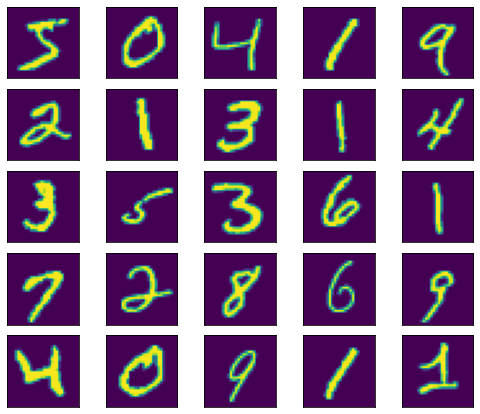

In [7]:
# Display 25 pictures of train data
do_eda(train_data)

# 4. Model Train and Evaluate Functions

In [8]:
def train_and_evaluate(model_x,X_train,y_train,epoch,X_val,y_val,X_test,y_test,plot_title,callbacks=[]):
  # Train and store the history of training
  hist_x = model_x.fit(X_train,y_train,epochs=epoch, validation_data = (X_val,y_val),callbacks=callbacks)

  # Plot all the accuracy and loss curves
  do_plot(hist_x,title = plot_title)

  # Evaluate Confusion and Classification report 
  eval_x = model_x.evaluate(X_test,y_test,verbose=1)
  do_eval(model_x,X_test,y_test)

  print("Training Accuracy is: ",np.average(hist_x.history['accuracy'][-5:]))
  print("Validation Accuracy is: ",np.average(hist_x.history['val_accuracy'][-5:]))
  print("Testing Accuracy is: ",eval_x[1])
  return hist_x,model_x

In [9]:
def do_plot(hist,title):
  print('\n\n')
  plt.figure(figsize=(14,5))
  plt.suptitle(title, fontsize=16,va='bottom')

  # Plot Accuracy of training and validation data
  plt.subplot(1,2,1)
  plt.grid(axis='both')
  plt.plot(np.linspace(0,hist.epoch[-1],len(hist.epoch)),hist.history['val_accuracy'],color='r',marker = 'o')
  plt.plot(np.linspace(0,hist.epoch[-1],len(hist.epoch)),hist.history['accuracy'],color='b',marker = 'o')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['Validation','Training'])
  plt.xlim(0,hist.epoch[-1])
  plt.xticks(ticks=hist.epoch)
  
  # Plot Loss of training and validation data
  plt.subplot(1,2,2)
  plt.grid(axis='both')
  plt.plot(np.linspace(0,hist.epoch[-1],len(hist.epoch)),hist.history['val_loss'],color='r',marker = 'o')
  plt.plot(np.linspace(0,hist.epoch[-1],len(hist.epoch)),hist.history['loss'],color='b',marker = 'o')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend(['Validation','Training'])
  plt.xlim(0,hist.epoch[-1])  
  plt.xticks(ticks=hist.epoch)
  
  plt.tight_layout()
  plt.show()  

In [10]:
def do_eval(model,X_test,y_test):
  pred_sparse = np.argmax(model.predict(X_test),axis=1)
  cm =confusion_matrix(y_test, pred_sparse,labels=[0,1,2,3,4,5,6,7,8,9])
  cr = classification_report(y_test, pred_sparse)
  print('Confusion Matrix\n',cm)
  print('Classification Report\n', cr)

  plt.figure()
  plt.imshow(cm)
  plt.xticks(ticks=[0,1,2,3,4,5,6,7,8,9],labels=class_names_str)
  plt.yticks(ticks=[0,1,2,3,4,5,6,7,8,9],labels=class_names_str)
  plt.ylabel('Y_True')  
  plt.xlabel('Y_Pred')
  plt.xticks(rotation=90)
  return

In [66]:
def plot_errors(model,train_data,train_labels,max_n = 25,plot_all = False):
  plt.figure(figsize=(7,7))
  
  # Check the shape and reshape if required
  if len(model.input_shape)==4:
    train_data_tensor = tf.reshape(train_data,shape = (len(train_data),28,28,1))
    pred_sparse = np.argmax(model.predict(train_data_tensor),axis=1)
    
  else:
    pred_sparse = np.argmax(model.predict(train_data),axis=1)
  
  if plot_all == True:
    indexes = np.linspace(0,len(train_data)-1,len(train_data),dtype=int)
    print(indexes)
  
  else:
    indexes = np.where(pred_sparse != train_labels)[0]
    print("Number of mislabelled samples:",len(indexes))
  
  indexes = np.random.permutation(indexes)

  if len(indexes)<max_n:
    max_n = len(indexes)
  # Show N samples
  
  for i in range(max_n):
    
    plt.subplot(math.ceil(max_n/5),5,i+1)
    plt.tick_params( which='both', bottom=False, left=False,top=False,labelbottom=False, labelleft=False) 
    # Get the class names from labels
    plt.xlabel('Predict:'+str(class_names[pred_sparse[indexes[i]]]))
    plt.title('Truth:'+str(class_names[train_labels[indexes[i]]]))
    plt.imshow(train_data[indexes[i]])
    
  plt.tight_layout()
  plt.show()

# 5. Model Setup NN

In [13]:
model_a=keras.Sequential([
    keras.layers.Flatten(input_shape=(28,28)),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dense(512,activation='relu'),
    keras.layers.Dense(256,activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
    ])
model_a.compile(optimizer='Adam',metrics=['accuracy'],loss='sparse_categorical_crossentropy')

Epoch 1/10
1875/1875 [==============================] - 6s 2ms/step - loss: 0.3520 - accuracy: 0.8910 - val_loss: 0.1162 - val_accuracy: 0.9675
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1013 - accuracy: 0.9710 - val_loss: 0.0890 - val_accuracy: 0.9685
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0712 - accuracy: 0.9794 - val_loss: 0.0935 - val_accuracy: 0.9765
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0638 - accuracy: 0.9827 - val_loss: 0.1226 - val_accuracy: 0.9790
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0491 - accuracy: 0.9860 - val_loss: 0.0836 - val_accuracy: 0.9815
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0406 - accuracy: 0.9886 - val_loss: 0.0859 - val_accuracy: 0.9805
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0292 - accuracy: 0.9917 - val_loss: 0.1049 - val_accuracy:

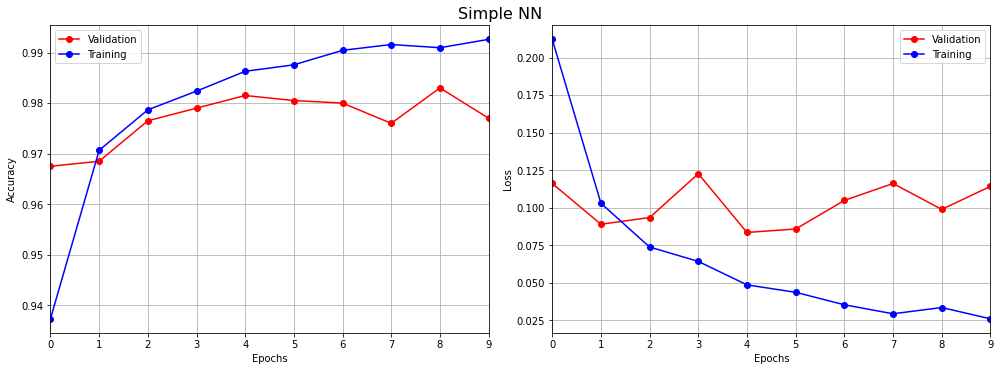

250/250 [==============================] - 1s 2ms/step - loss: 0.1469 - accuracy: 0.9746
Confusion Matrix
 [[779   1   0   1   0   0   1   1   2   0]
 [  0 903   2   1   0   0   1   1   6   0]
 [  3   0 784   4   0   0   0   0  10   0]
 [  0   0   2 803   0   2   0   0  14   2]
 [  0   0   5   1 770   0   3   1   3   6]
 [  1   1   0  14   0 684   2   0  10   2]
 [  2   1   0   1   1   3 736   0   3   0]
 [  3   2  10  23   0   0   0 769   5   4]
 [  0   0   1   2   0   0   2   0 786   1]
 [  2   0   2   6   7   2   0   5  12 783]]
Classification Report
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       785
           1       0.99      0.99      0.99       914
           2       0.97      0.98      0.98       801
           3       0.94      0.98      0.96       823
           4       0.99      0.98      0.98       789
           5       0.99      0.96      0.97       714
           6       0.99      0.99      0.99       747
      

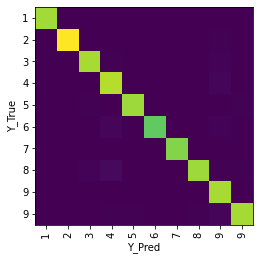

In [14]:
hist_a,model_a = train_and_evaluate(model_a,X_train,y_train,10,X_val,y_val,X_test,y_test,"Simple NN")

Number of mislabelled samples: 547


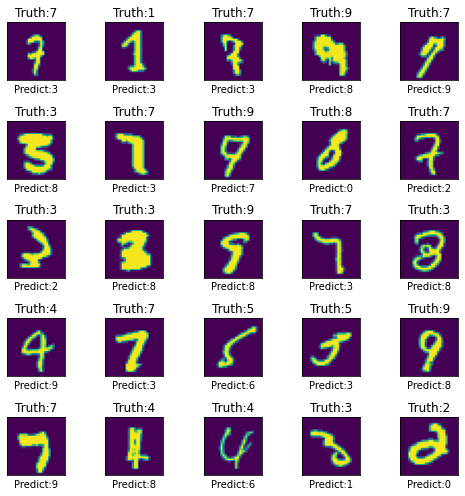

In [67]:
plot_errors(model_a,train_data,train_labels)

# 6. Model Setup CNN

In [16]:
model_b=keras.Sequential()
model_b.add(keras.layers.Conv2D(32,(3,3),activation='relu', input_shape=(28,28,1)))
model_b.add(keras.layers.Conv2D(32,(3,3),activation='relu'))
model_b.add(keras.layers.MaxPool2D((2,2)))
model_b.add(keras.layers.BatchNormalization())
model_b.add(keras.layers.Dropout(0.1))
model_b.add(keras.layers.Conv2D(64,(3,3), activation='relu'))
model_b.add(keras.layers.Conv2D(64,(3,3), activation='relu'))
model_b.add(keras.layers.MaxPool2D((2,2)))
model_b.add(keras.layers.BatchNormalization())
model_b.add(keras.layers.Dropout(0.15))
model_b.add(keras.layers.Conv2D(128,(3,3), activation='relu'))
# model_b.add(keras.layers.Conv2D(128,(3,3), activation='relu'))
model_b.add(keras.layers.MaxPool2D((2,2)))
model_b.add(keras.layers.Flatten())
model_b.add(keras.layers.Dropout(0.3))
model_b.add(keras.layers.Dense(1024, activation='relu'))
model_b.add(keras.layers.Dropout(0.1))
model_b.add(keras.layers.Dense(256, activation='relu'))
model_b.add(keras.layers.Dense(10,activation='softmax'))
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model_b.compile(optimizer=opt,loss='sparse_categorical_crossentropy',metrics='accuracy')

In [17]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
callbacks_list_default = [
        # reduce learning rate by a factor of 5 (i.e. lr/=5.0) 
        # if val_loss does not reduce for 3 epochs
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            verbose=1
        ),
        # Stop training if val_acc does not improve for
        # 5 or more epochs
        EarlyStopping(
            monitor='val_accuracy',
            patience=6,
            verbose=1        
        )
    ]

Epoch 1/20
1875/1875 [==============================] - 35s 4ms/step - loss: 0.3000 - accuracy: 0.9062 - val_loss: 0.0364 - val_accuracy: 0.9915
Epoch 2/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0667 - accuracy: 0.9811 - val_loss: 0.0595 - val_accuracy: 0.9825
Epoch 3/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0595 - accuracy: 0.9832 - val_loss: 0.0313 - val_accuracy: 0.9915
Epoch 4/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0470 - accuracy: 0.9869 - val_loss: 0.0342 - val_accuracy: 0.9895
Epoch 5/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0423 - accuracy: 0.9879 - val_loss: 0.0180 - val_accuracy: 0.9960
Epoch 6/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0400 - accuracy: 0.9890 - val_loss: 0.0328 - val_accuracy: 0.9905
Epoch 7/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0366 - accuracy: 0.9907 - val_loss: 0.0165 - val_accuracy

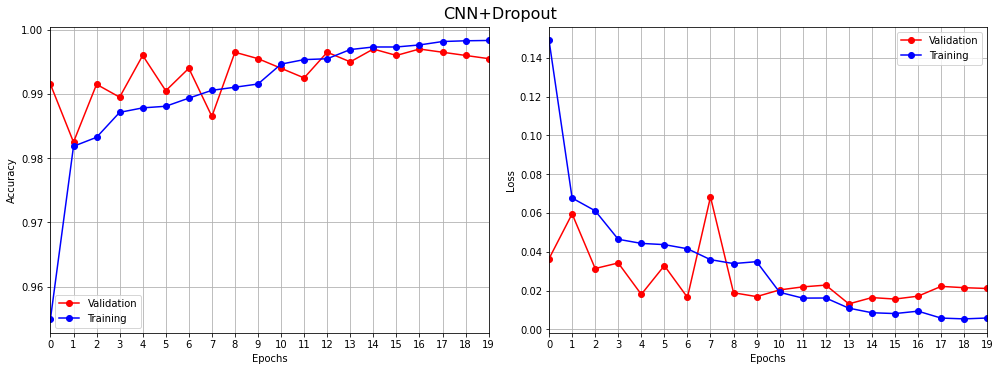

250/250 [==============================] - 1s 2ms/step - loss: 0.0235 - accuracy: 0.9945
Confusion Matrix
 [[783   0   0   0   0   0   1   1   0   0]
 [  0 912   0   0   0   1   1   0   0   0]
 [  0   0 796   3   0   0   0   2   0   0]
 [  0   0   0 820   0   2   0   0   1   0]
 [  0   0   0   0 786   0   0   0   0   3]
 [  1   0   0   4   0 708   1   0   0   0]
 [  2   1   1   0   0   1 741   0   1   0]
 [  0   4   1   0   0   0   0 809   0   2]
 [  0   0   1   1   0   1   0   0 788   1]
 [  0   0   0   0   2   0   0   1   3 813]]
Classification Report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       785
           1       0.99      1.00      1.00       914
           2       1.00      0.99      0.99       801
           3       0.99      1.00      0.99       823
           4       1.00      1.00      1.00       789
           5       0.99      0.99      0.99       714
           6       1.00      0.99      0.99       747
      

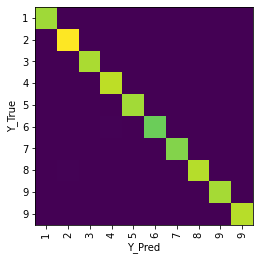

In [18]:
hist_e,model_b = train_and_evaluate(model_b,X_train,y_train,20,X_val,y_val,X_test,y_test,"CNN+Dropout",callbacks=callbacks_list_default)

Number of mislabelled samples: 14


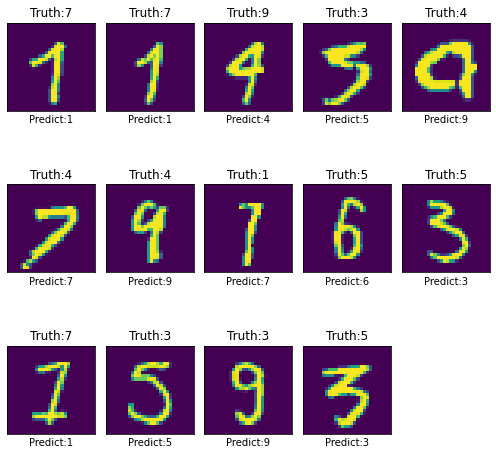

In [68]:
plot_errors(model_b,train_data,train_labels)

[    0     1     2 ... 59997 59998 59999]


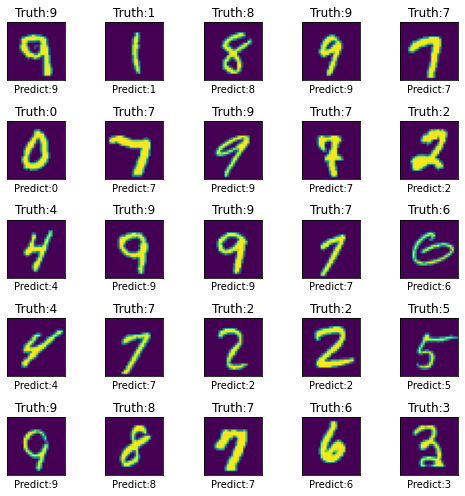

In [69]:
plot_errors(model_b,train_data,train_labels,plot_all=True)

# 7. Observations and Conclusions

* Based on error analysis, most errors were due to mislabelling of classes.
* A few examples had images that were harder to classify even for the human eye, like a 1-7 or a 6-8.  These can be considered corner cases. 
* The model is performing on par to a human.